[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Deploying large deep neural network models is a challenge, especially when edge devices with limited memory and computational power are in the equation. To overcome this challenge, the “Knowledge Distillation” technique arose as a form of model compression. This method focuses on the process of transferring knowledge from a large model to a smaller model that can be practically deployed under real-world constraints. It was first successfully demonstrated by Bucilua et al., (2006) [1] and then, popularized by Hinton et al., (2015) [2]. The real challenge is to implement this mechanism without a significant loss in performance. In the case of current SOTA neural networks, knowledge distillation has arisen as a possibility to compress all those millions of weights and tens of processing layers. In this notebook, this technique is implemented. We have used this tutorial as a source: https://keras.io/examples/vision/knowledge_distillation/ 



#### Library Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.applications import mobilenet_v3
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

#### Auxiliar functions
Check the docstrings for more information.

In [3]:
# Function for plotting images.
def plot_samples(dataset):
    sample_images, sample_labels = next(iter(dataset))
  
    plt.figure(figsize=(8, 8))
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(3, 3, ix+1)
        plt.imshow(sample_image.numpy().astype(np.uint8))
        plt.axis("off")
    
    plt.show()

def read_data(path_list, im_size=(224,224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) # Convert list to numpy array.
    y = np.array(y).astype(np.uint8)
    
    return X, y

# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [    
        # If val_loss doesn't improve for a number of epochs set with 'patience' var 
        # training will stop to avoid overfitting.     
        EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience = patience,
                      restore_best_weights=True,
                      verbose=1),
        ModelCheckpoint(filepath='best-weights.h5', 
                     verbose=1, monitor='val_loss', 
                     save_weights_only=True, 
                     save_best_only=True
                 )   
        ]

### Knowledge Distillation
Source: https://keras.io/examples/vision/knowledge_distillation/

The custom Distiller() class, overrides the Model methods train_step, test_step, and compile(). To use the distiller, we need:
1. A trained teacher model
2. A student model to train
3. A student loss function on the difference between student predictions and ground-truth
4. A distillation loss function, along with a temperature, on the difference between the soft student predictions and the soft teacher labels
5. An alpha factor to weigh the student and distillation loss
6. An optimizer for the student and (optional) metrics to evaluate the performance

In the train_step method, we perform a forward pass of both the teacher and student, calculate the loss with the weighting of the student_loss and distillation_loss by alpha and 1 - alpha, respectively, and perform the backward pass. Note: only the student weights are updated, and therefore we only calculate the gradients for the student weights.

In the test_step method, we evaluate the student model on the provided dataset.

In [4]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### Experimental Constants

In [78]:
INPUT_SHAPE = (128, 128, 3)
IM_SIZE = (128, 128)
NUM_EPOCHS = 30
BATCH_SIZE = 16
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2022
WEIGHTS_FILE = "weights.h5"# File that stores updated weights
AUTO = tf.data.AUTOTUNE
BASE_PATH = "eden_library_datasets" + os.path.sep

# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Cucumber-Cucumis_sativus-Healthy-PRX-RGB-NA-20210607/images",
    BASE_PATH + "Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20210410/images",
    BASE_PATH + "Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20210607/images",
    BASE_PATH + "Processing_tomato-Lycopersicum_esculentum-Healthy-PRX-RGB-NA-20200731/images",
    BASE_PATH + "Tomato-240519-Healthy-zz-V1-202102251037402",
    BASE_PATH + "Black nightsade-220519-Weed-zz-V1-20210225102034",
    BASE_PATH + "Cotton-100619-Healthy-zz-V1-20210225102300",
    BASE_PATH + "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images and Data Loaders

In [ ]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X, y = read_data(PATH_LIST, IM_SIZE)

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 130/202 [00:42<00:26,  2.73it/s]

Not a picture


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 75/124 [00:16<00:10,  4.63it/s]

Not a picture


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 112/124 [00:24<00:02,  4.85it/s]

#### Creating the Teacher

In [66]:
# Create the teacher
teacher = Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10)
])

teacher.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["accuracy"])
#model.summary()

#### Creating the Datasets and Splitting the data

In [67]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = (
    train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Displaying some samples

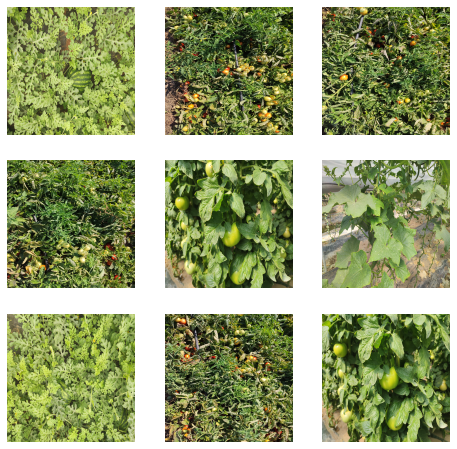

In [68]:
plot_samples(train_ds)

#### Training the Teacher

In [69]:
%%time
history_teacher = teacher.fit(train_ds, # train data
                              validation_data=val_ds, # labels
                              epochs=NUM_EPOCHS,
                              callbacks=get_callbacks(NUM_EPOCHS//2))

Epoch 1/30
25/36 [===================>..........] - ETA: 0s - loss: 1.2055 - accuracy: 0.8975
Epoch 1: val_loss improved from inf to 52.82468, saving model to best-weights.h5
36/36 [==============================] - 1s 12ms/step - loss: 0.8411 - accuracy: 0.9271 - val_loss: 52.8247 - val_accuracy: 0.4583
Epoch 2/30
26/36 [====================>.........] - ETA: 0s - loss: 0.1240 - accuracy: 0.9928  
Epoch 2: val_loss improved from 52.82468 to 24.20778, saving model to best-weights.h5
36/36 [==============================] - 0s 7ms/step - loss: 0.1069 - accuracy: 0.9931 - val_loss: 24.2078 - val_accuracy: 0.6042
Epoch 3/30
36/36 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9948
Epoch 3: val_loss improved from 24.20778 to 0.00000, saving model to best-weights.h5
36/36 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9948 - val_loss: 1.6557e-08 - val_accuracy: 1.0000
Epoch 4/30
25/36 [===================>..........] - ETA: 0s - loss: 0.

#### Evaluating the Teacher

In [70]:
teacher.load_weights("best-weights.h5")
print()
print("*"*50)
print(f"Clean Test Accuracy: {teacher.evaluate(test_ds, verbose=0)[1]}")
print("*"*50)
print()


**************************************************
Clean Test Accuracy: 1.0
**************************************************



#### Creating the Student

In [73]:
student = keras.Sequential(
    [
        layers.Conv2D(filters=2, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=INPUT_SHAPE),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(2, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10)
    ],
    name="student",
)

student_scratch = keras.models.clone_model(student)

#### Training the Student by Knowledge Distillation

In [74]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn = keras.losses.KLDivergence(),
    alpha = 0.5,
    temperature=10
)

distiller.fit(x_train, y_train, epochs=30)

Epoch 1/30
18/18 [==============================] - 1s 4ms/step - sparse_categorical_accuracy: 0.4653 - student_loss: 3.6355 - distillation_loss: 193.0044
Epoch 2/30
18/18 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 0.4948 - student_loss: 3.4314 - distillation_loss: 179.8916
Epoch 3/30
18/18 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 0.4861 - student_loss: 2.4460 - distillation_loss: 169.2224
Epoch 4/30
18/18 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 0.7049 - student_loss: 1.5718 - distillation_loss: 159.0974
Epoch 5/30
18/18 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 1.0000 - student_loss: 1.1594 - distillation_loss: 144.8327
Epoch 6/30
18/18 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 1.0000 - student_loss: 1.0832 - distillation_loss: 126.2608
Epoch 7/30
18/18 [==============================] - 0s 4ms/step - spar

#### Evaluating the Student

In [75]:
student.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=keras.metrics.SparseCategoricalAccuracy()
)
#student.load_weights("best-weights.h5")
print()
print("*"*50)
print(f"Clean Test Accuracy: {student.evaluate(test_ds, verbose=0)[1]}")
print("*"*50)
print()


**************************************************
Clean Test Accuracy: 1.0
**************************************************



#### Training the Student WITHOUT Knowledge Distillation

In [76]:
student_scratch.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=keras.metrics.SparseCategoricalAccuracy()
)

In [77]:
%%time
history_student = student_scratch.fit(train_ds,
                                      validation_data=val_ds,
                                      epochs=NUM_EPOCHS,
                                      callbacks=get_callbacks(NUM_EPOCHS//2))

Epoch 1/30
19/36 [==============>...............] - ETA: 0s - loss: 2.3436 - sparse_categorical_accuracy: 0.9243     
Epoch 1: val_loss improved from inf to 2.23843, saving model to best-weights.h5
36/36 [==============================] - 1s 6ms/step - loss: 2.3015 - sparse_categorical_accuracy: 0.9601 - val_loss: 2.2384 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
32/36 [=========================>....] - ETA: 0s - loss: 2.2110 - sparse_categorical_accuracy: 1.0000
Epoch 2: val_loss improved from 2.23843 to 2.17478, saving model to best-weights.h5
36/36 [==============================] - 0s 5ms/step - loss: 2.2074 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.1748 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
35/36 [============================>.] - ETA: 0s - loss: 2.1450 - sparse_categorical_accuracy: 1.0000
Epoch 3: val_loss improved from 2.17478 to 2.11183, saving model to best-weights.h5
36/36 [==============================] - 0s 4ms/step - loss: 2.1441 - spar

36/36 [==============================] - 0s 4ms/step - loss: 1.0890 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0682 - val_sparse_categorical_accuracy: 1.0000
Epoch 24/30
36/36 [==============================] - ETA: 0s - loss: 1.0489 - sparse_categorical_accuracy: 1.0000
Epoch 24: val_loss improved from 1.06818 to 1.02882, saving model to best-weights.h5
36/36 [==============================] - 0s 4ms/step - loss: 1.0489 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0288 - val_sparse_categorical_accuracy: 1.0000
Epoch 25/30
34/36 [===========================>..] - ETA: 0s - loss: 1.0113 - sparse_categorical_accuracy: 1.0000
Epoch 25: val_loss improved from 1.02882 to 0.99074, saving model to best-weights.h5
36/36 [==============================] - 0s 5ms/step - loss: 1.0102 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 1.0000
Epoch 26/30
34/36 [===========================>..] - ETA: 0s - loss: 0.9738 - sparse_categorical_accu

#### Evaluating the Student trained WITHOUT Knowledge Distillation

In [61]:
student_scratch.load_weights("best-weights.h5")
print()
print("*"*50)
print(f"Clean Test Accuracy: {student_scratch.evaluate(test_ds, verbose=0)[1]}")
print("*"*50)
print()


**************************************************
Clean Test Accuracy: 1.0
**************************************************



## Conclusions
Knowledge Distillation can both reduce the size of the model and boost its performance.

## Possible Extensions
1. Use a different architecture in both Teacher and Student.
2. Try a different training approach where pre-trained weights are loaded.
3. Try different epochs, batch sizes and learning rates.

## Bibliography

[1] Bucila, C., Caruana, R., & Niculescu-Mizil, A. (2006). Model compression. Knowledge Discovery and Data Mining.

[2] Hinton, G.E., Vinyals, O., & Dean, J. (2015). Distilling the Knowledge in a Neural Network. ArXiv, abs/1503.02531.
